In [2]:
#Imports 
import os
import json
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os
import json
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# -----------------------------
# Helper functions
# -----------------------------
def clean_text(text):
    """Lowercase, remove non-alphanumerics, remove stopwords."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)

def load_cuad_jsons(json_folder):
    """
    Load all CUAD JSON files in a folder, extract clause text and labels.
    Returns a DataFrame with columns ['clause_text', 'label'].
    """
    data = []

    for root, dirs, files in os.walk(json_folder):
        for filename in files:
            if filename.endswith('.json'):
                filepath = os.path.join(root, filename)
                with open(filepath, 'r', encoding='utf-8') as f:
                    doc = json.load(f)

                # Phase 2 style: each JSON has a 'data' list
                for contract in doc.get('data', []):
                    for paragraph in contract.get('paragraphs', []):
                        for qa in paragraph.get('qas', []):
                            label = qa.get('question', 'Unknown')
                            for answer in qa.get('answers', []):
                                clause_text = answer.get('text', '').strip()
                                if clause_text:
                                    cleaned_text = clean_text(clause_text)
                                    data.append({'clause_text': cleaned_text, 'label': label})

    df = pd.DataFrame(data)
    return df

def prepare_train_test(df, test_size=0.2, random_state=42):
    """Clean DataFrame and split into train/test sets with label encoding."""
    df = df.dropna(subset=['clause_text', 'label'])
    df = df[df['clause_text'].str.strip() != '']
    df['label'] = df['label'].astype('category')
    df['label_id'] = df['label'].cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        df['clause_text'],
        df['label_id'],
        test_size=test_size,
        random_state=random_state,
        stratify=df['label_id']
    )
    return X_train, X_test, y_train, y_test, df

# -----------------------------
# Main pipeline
# -----------------------------
# Paths
zip_path = "/Users/michaelpancras/Desktop/AI_Legal_Assistant/CUAD_v1.zip"
extract_path = "/Users/michaelpancras/Desktop/AI_Legal_Assistant/cuad_data"

# Unzip CUAD (if not already)
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Locate folder with JSON files
json_folder = None
for root, dirs, files in os.walk(extract_path):
    if any(f.endswith('.json') for f in files):
        json_folder = root
        break

if json_folder is None:
    raise ValueError("No JSON files found!")

print(f"Loading JSON files from: {json_folder}")

# Load and process all clauses
df = load_cuad_jsons(json_folder)
print(f"Loaded {len(df)} clauses.")

# Prepare train/test splits
X_train, X_test, y_train, y_test, df_full = prepare_train_test(df)
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print("Example clause text:", X_train.iloc[0])
print("Example label id:", y_train.iloc[0])
print("Label mapping:", dict(enumerate(df_full['label'].cat.categories)))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelpancras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading JSON files from: /Users/michaelpancras/Desktop/AI_Legal_Assistant/cuad_data/CUAD_v1
Loaded 13823 clauses.
Train samples: 11033, Test samples: 2759
Example clause text: company
Example label id: 28
Label mapping: {0: 'Highlight the parts (if any) of this contract related to "Affiliate License-Licensee" that should be reviewed by a lawyer. Details: Does the contract contain a license grant to a licensee (incl. sublicensor) and the affiliates of such licensee/sublicensor?', 1: 'Highlight the parts (if any) of this contract related to "Affiliate License-Licensor" that should be reviewed by a lawyer. Details: Does the contract contain a license grant by affiliates of the licensor or that includes intellectual property of affiliates of the licensor?\xa0', 2: 'Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract', 3: 'Highlight the parts (if any) of this contract related to "Anti-Assignment" th

In [8]:
# -----------------------------
# Step 2: Tokenization & Vectorization
# -----------------------------

# ----- Option 1: Classical ML (TF-IDF) -----
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF feature shape:", X_train_tfidf.shape)
print("Example TF-IDF feature vector (sparse):", X_train_tfidf[0])

# ----- Option 2: Transformers (LegalBERT) -----
from transformers import AutoTokenizer

# Load LegalBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

# Tokenize train/test sets
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="pt"
)

print("Sample LegalBERT input ids:", train_encodings['input_ids'][0][:20])

TF-IDF feature shape: (11033, 5000)
Example TF-IDF feature vector (sparse):   (0, 897)	1.0


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sample LegalBERT input ids: tensor([101, 243, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])


In [14]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression on TF-IDF features
lr_model = LogisticRegression(max_iter=200, class_weight="balanced")
lr_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained on TF-IDF features.")

Logistic Regression model trained on TF-IDF features.


TF-IDF + Logistic Regression Accuracy: 0.73

Classification Report (zero_division=0 to avoid warnings):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        precision    recall  f1-score   support

                                                                                                                                                                                                                                                                      Highlight the parts (if any) of this contract related to "Affiliate Licen

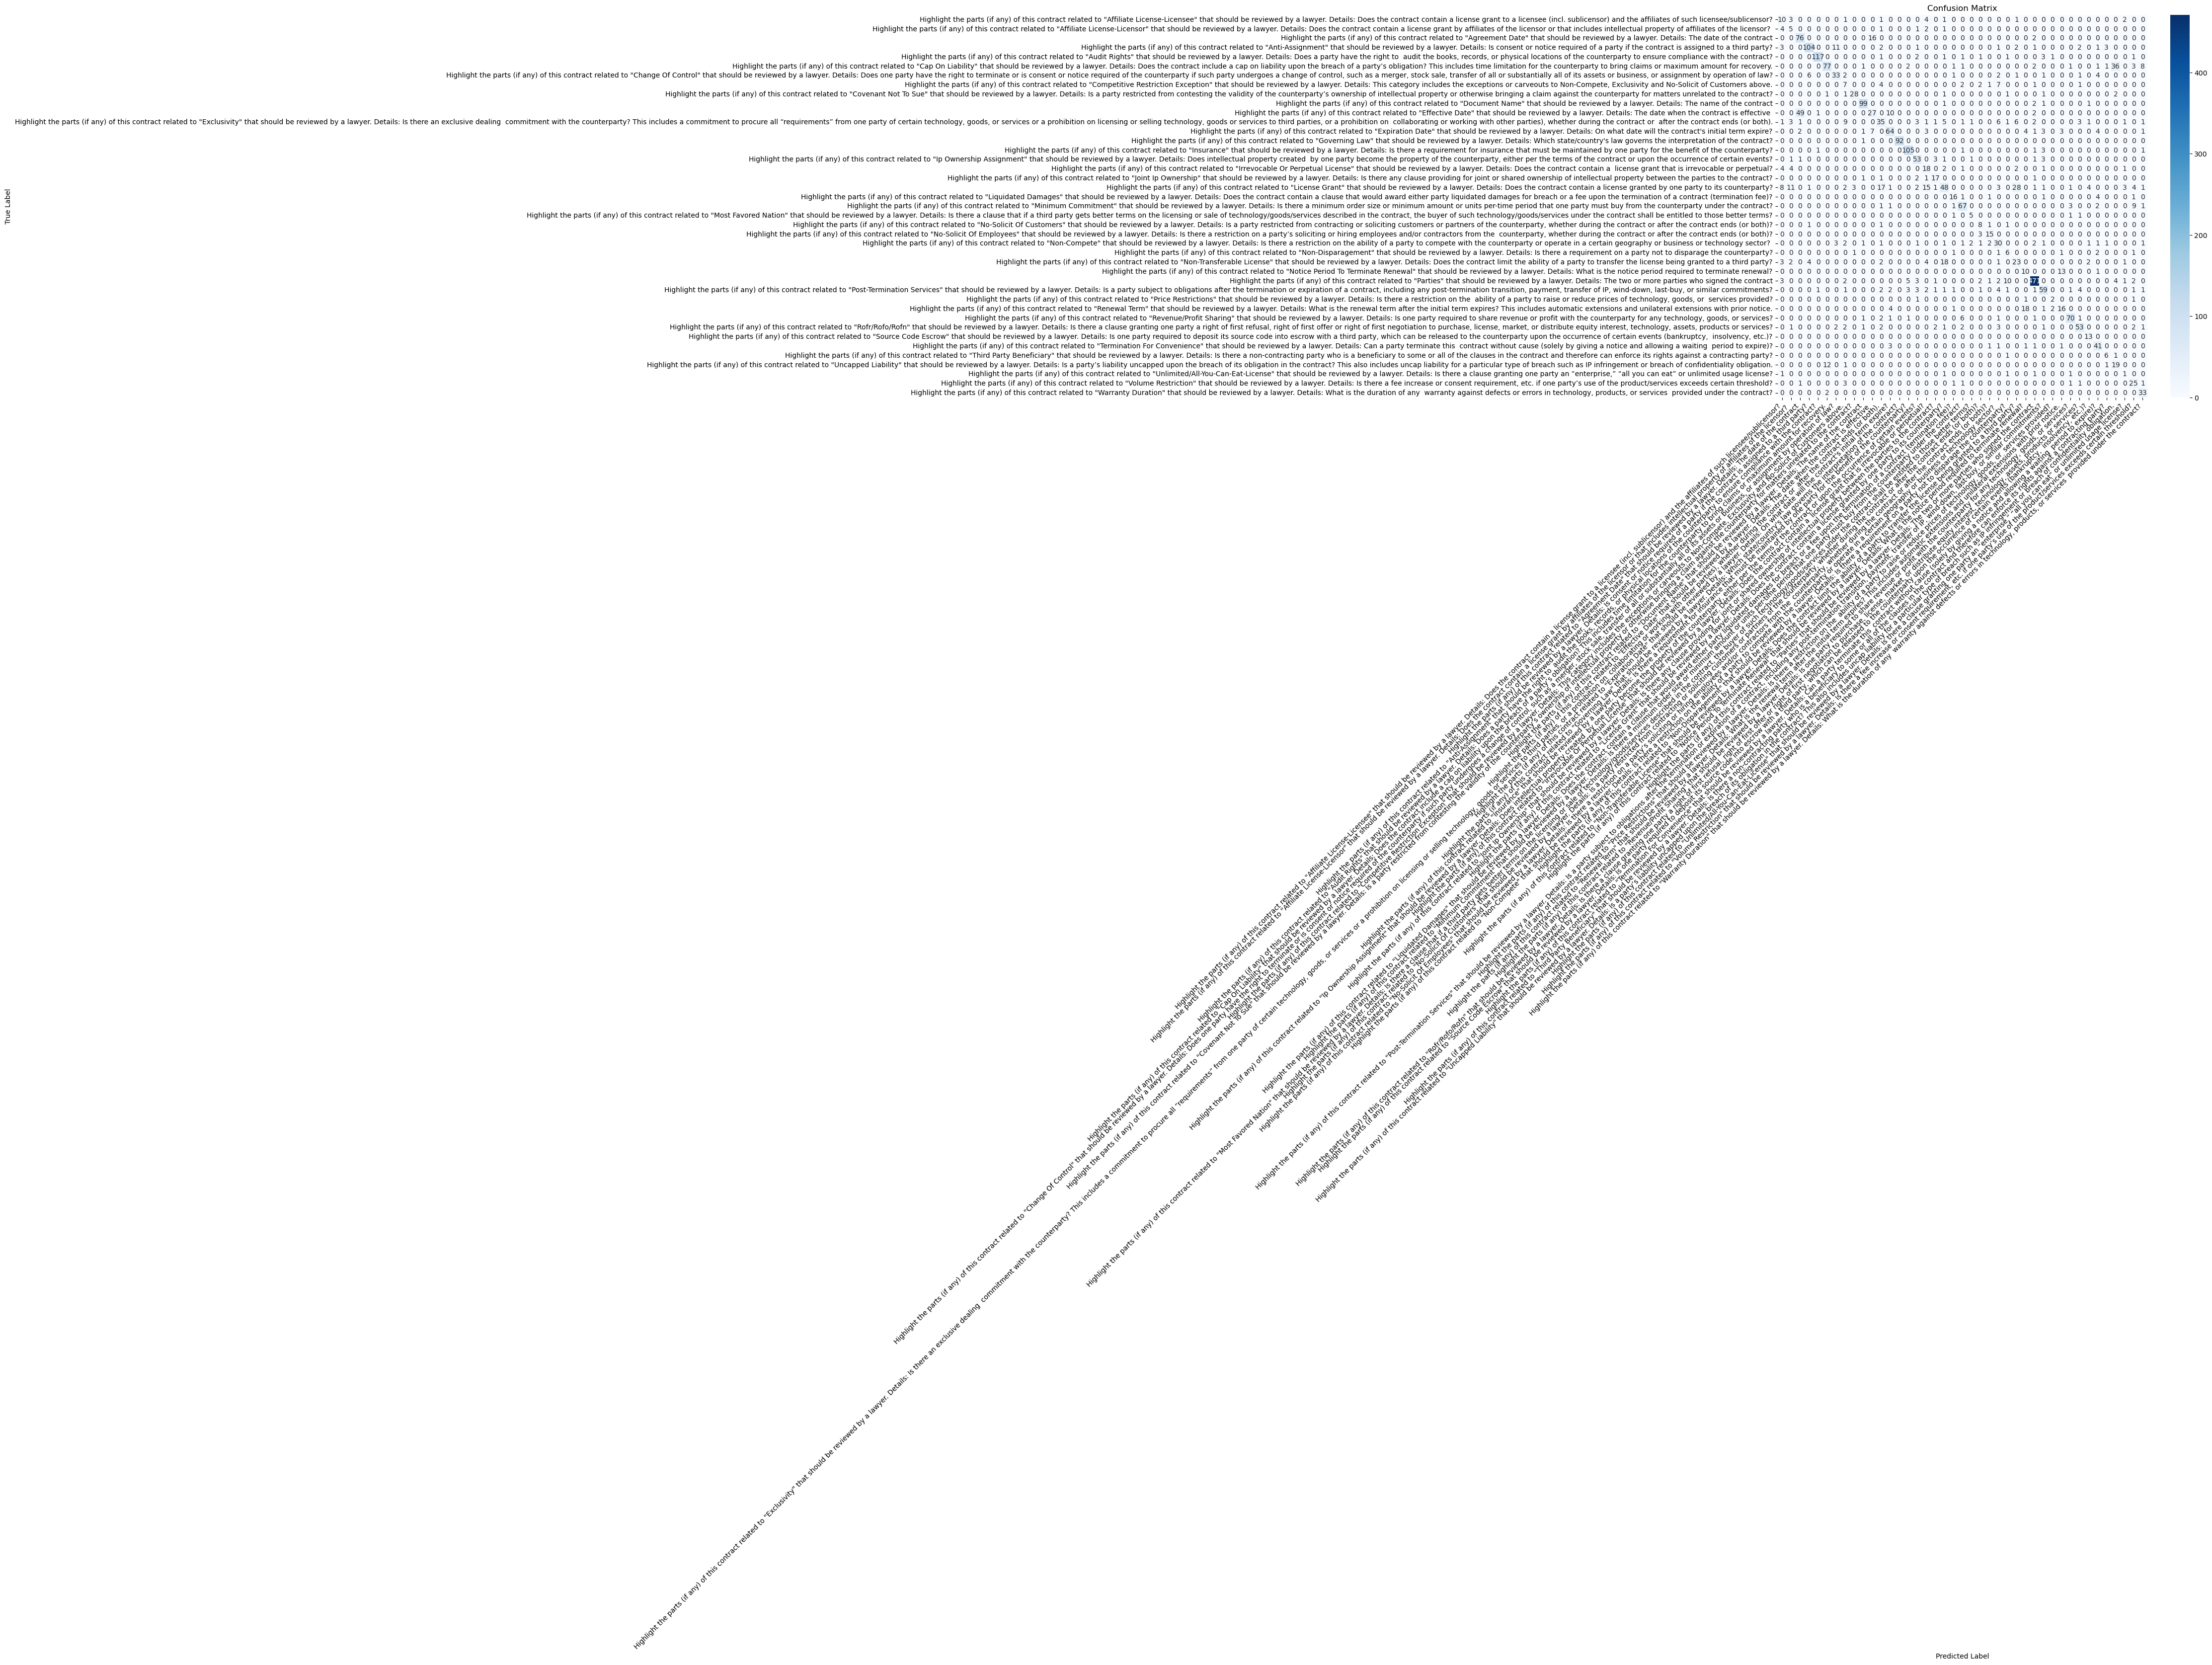

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Predictions
# -----------------------------
y_pred = lr_model.predict(X_test_tfidf)

# -----------------------------
# Evaluation: Accuracy
# -----------------------------
acc = accuracy_score(y_test, y_pred)
print(f"TF-IDF + Logistic Regression Accuracy: {acc:.2f}\n")

# -----------------------------
# Evaluation: Classification Report
# -----------------------------
print("Classification Report (zero_division=0 to avoid warnings):")
print(classification_report(
    y_test,
    y_pred,
    target_names=df_full['label'].cat.categories,
    zero_division=0  # avoids the UndefinedMetricWarning
))

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=df_full['label'].cat.categories, yticklabels=df_full['label'].cat.categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [18]:
df = load_cuad_jsons(json_folder)
X_train, X_test, y_train, y_test, df_full = prepare_train_test(df)

In [28]:
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch, numpy as np, os, time
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ------- speed toggles -------
MAX_LEN    = 64     # 32 or 48 is much faster on CPU
BATCH      = 8
EPOCHS     = 3
TRAIN_CAP  = 1200   # cap train set BEFORE tokenizing (None = full)
TEST_CAP   = 600
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_num_threads(2)

device = torch.device("cpu")
print("Using device:", device)

# Ensure positional indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# ---- cap BEFORE tokenization (big speedup) ----
if TRAIN_CAP is not None:
    X_train = X_train.iloc[:TRAIN_CAP]
    y_train = y_train.iloc[:TRAIN_CAP]
if TEST_CAP is not None:
    X_test  = X_test.iloc[:TEST_CAP]
    y_test  = y_test.iloc[:TEST_CAP]

# ---- tokenizer/model ----
MODEL_NAME = "nlpaueb/legal-bert-base-uncased"  # LegalBERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_batch(texts, max_len=MAX_LEN):
    print(f"Tokenizing {len(texts)} samples (max_len={max_len})...")
    t0 = time.perf_counter()
    enc = tokenizer(
        list(map(str, texts)),
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt"
    )
    print(f"Tokenization done in {time.perf_counter() - t0:.1f}s")
    return enc

train_enc = encode_batch(X_train, MAX_LEN)
test_enc  = encode_batch(X_test,  MAX_LEN)

y_train_np = np.array(y_train, dtype=int)
y_test_np  = np.array(y_test, dtype=int)
num_labels = int(len(set(np.concatenate([y_train_np, y_test_np]))))

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels
).to(device)

# ---- dataset wrappers ----
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels_np):
        self.enc = encodings
        self.labels = labels_np
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {
            "input_ids": self.enc["input_ids"][idx],
            "attention_mask": self.enc["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_ds = EncodedDataset(train_enc, y_train_np)
test_ds  = EncodedDataset(test_enc,  y_test_np)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

# ---- optimizer ----
optimizer = AdamW(model.parameters(), lr=2e-5)

# ---- training loop ----
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    t_epoch = time.perf_counter()
    nb = len(train_loader)
    for i, batch in enumerate(train_loader, 1):
        optimizer.zero_grad()
        out = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["labels"].to(device)
        )
        loss = out.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 25 == 0 or i == nb:
            print(f"epoch {epoch+1} | step {i}/{nb} | avg loss {total_loss/i:.4f}")
    print(f"Epoch {epoch+1} done in {time.perf_counter()-t_epoch:.1f}s | avg loss {total_loss/nb:.4f}")

# ---- eval ----
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        logits = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        ).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(batch["labels"].cpu().numpy().tolist())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, zero_division=0))

Using device: cpu
Tokenizing 1200 samples (max_len=64)...
Tokenization done in 0.1s
Tokenizing 600 samples (max_len=64)...


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenization done in 0.0s


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 1 | step 25/150 | avg loss 3.5929
epoch 1 | step 50/150 | avg loss 3.3984
epoch 1 | step 75/150 | avg loss 3.3184
epoch 1 | step 100/150 | avg loss 3.1851
epoch 1 | step 125/150 | avg loss 3.0854
epoch 1 | step 150/150 | avg loss 3.0200
Epoch 1 done in 140.8s | avg loss 3.0200
epoch 2 | step 25/150 | avg loss 2.3735
epoch 2 | step 50/150 | avg loss 2.2625
epoch 2 | step 75/150 | avg loss 2.2176
epoch 2 | step 100/150 | avg loss 2.1464
epoch 2 | step 125/150 | avg loss 2.0863
epoch 2 | step 150/150 | avg loss 2.0492
Epoch 2 done in 102.7s | avg loss 2.0492
epoch 3 | step 25/150 | avg loss 1.5748
epoch 3 | step 50/150 | avg loss 1.5753
epoch 3 | step 75/150 | avg loss 1.5400
epoch 3 | step 100/150 | avg loss 1.5183
epoch 3 | step 125/150 | avg loss 1.4891
epoch 3 | step 150/150 | avg loss 1.4705
Epoch 3 done in 116.9s | avg loss 1.4705
Accuracy: 0.675
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5

In [30]:
# ==== Phase 3: imbalance-aware training with scheduler + early stopping ====
import numpy as np, torch, torch.nn.functional as F, time
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report

# derive label names if you have df_full; else synthetic names
try:
    label_names = df_full['label'].cat.categories.tolist()
except Exception:
    label_names = [f"label_{i}" for i in sorted(set(np.concatenate([y_train_np, y_test_np])))]

num_labels = len(label_names)

# ---- class weights (inverse frequency, normalized) ----
counts = np.bincount(y_train_np, minlength=num_labels)
class_weights = (counts.sum() / np.maximum(counts, 1)).astype(np.float32)
class_weights = class_weights / class_weights.mean()
cw_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights (first 10):", class_weights[:10])

# ---- scheduler (linear warmup/decay) ----
EPOCHS_TUNED = 5  # quick but meaningful; keep small on CPU
total_steps = EPOCHS_TUNED * len(train_loader)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

# ---- early stopping on macro-F1 ----
best_macro_f1 = -1.0
patience = 2
since_improved = 0
best_state = None

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            logits = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            ).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return acc, macro_f1, (all_labels, all_preds)

print(f"Fine-tuning (EPOCHS={EPOCHS_TUNED}, MAX_LEN={MAX_LEN}, BATCH={BATCH})")
t0 = time.perf_counter()
for epoch in range(1, EPOCHS_TUNED + 1):
    model.train()
    total_loss = 0.0
    ep_start = time.perf_counter()
    for step, batch in enumerate(train_loader, 1):
        optimizer.zero_grad()
        out = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )
        # weighted loss to fight class imbalance
        loss = F.cross_entropy(out.logits, batch["labels"].to(device), weight=cw_t)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        if step % 25 == 0 or step == len(train_loader):
            print(f"epoch {epoch} | step {step}/{len(train_loader)} | avg loss {total_loss/step:.4f}")

    acc, macro_f1, (y_true, y_pred) = evaluate(model, test_loader)
    print(f"Epoch {epoch} in {time.perf_counter()-ep_start:.1f}s | "
          f"train loss {total_loss/len(train_loader):.4f} | "
          f"VAL acc {acc:.3f} | VAL macroF1 {macro_f1:.3f}")

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        since_improved = 0
    else:
        since_improved += 1
        if since_improved >= patience:
            print("Early stopping (no macro-F1 improvement).")
            break

print(f"Total fine-tune time: {time.perf_counter()-t0:.1f}s | Best macro-F1: {best_macro_f1:.3f}")
if best_state is not None:
    model.load_state_dict(best_state)

Class weights (first 10): [0.94581074 1.486274   0.23645268 0.20807835 0.20399839 0.2167483
 0.3853303  0.6935945  0.5201959  0.22617212]
Fine-tuning (EPOCHS=5, MAX_LEN=64, BATCH=8)
epoch 1 | step 25/150 | avg loss 2.1477
epoch 1 | step 50/150 | avg loss 1.9276
epoch 1 | step 75/150 | avg loss 1.8828
epoch 1 | step 100/150 | avg loss 1.9028
epoch 1 | step 125/150 | avg loss 1.8830
epoch 1 | step 150/150 | avg loss 1.8711
Epoch 1 in 136.4s | train loss 1.8711 | VAL acc 0.695 | VAL macroF1 0.450
epoch 2 | step 25/150 | avg loss 1.6869
epoch 2 | step 50/150 | avg loss 1.5927
epoch 2 | step 75/150 | avg loss 1.5868
epoch 2 | step 100/150 | avg loss 1.5681
epoch 2 | step 125/150 | avg loss 1.5542
epoch 2 | step 150/150 | avg loss 1.5040
Epoch 2 in 121.4s | train loss 1.5040 | VAL acc 0.705 | VAL macroF1 0.498
epoch 3 | step 25/150 | avg loss 1.2231
epoch 3 | step 50/150 | avg loss 1.2613
epoch 3 | step 75/150 | avg loss 1.2760
epoch 3 | step 100/150 | avg loss 1.2698
epoch 3 | step 125/150 

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# final eval
acc, macro_f1, (y_true, y_pred) = evaluate(model, test_loader)
print("Final Accuracy:", acc)
print("Final Macro-F1:", macro_f1)

# --- align labels & names to what's present ---
labels_used = sorted(set(y_true) | set(y_pred))
names_used  = [label_names[i] for i in labels_used]

# optional: tell us which classes were missing in this split
all_ids = set(range(len(label_names)))
missing = sorted(list(all_ids - set(labels_used)))
if missing:
    print(f"(Note) {len(missing)} classes absent in eval: {[label_names[i] for i in missing][:10]}{' ...' if len(missing)>10 else ''}")

print("Classification Report:\n",
      classification_report(y_true, y_pred,
                            labels=labels_used,
                            target_names=names_used,
                            zero_division=0))

# Confusion matrix using only the present labels
cm = confusion_matrix(y_true, y_pred, labels=labels_used)

# Top confusions (off-diagonal)
confusions = []
for i_i, i in enumerate(labels_used):
    for j_j, j in enumerate(labels_used):
        if i != j and cm[i_i, j_j] > 0:
            confusions.append((cm[i_i, j_j], label_names[i], "→", label_names[j]))
confusions.sort(reverse=True)
print("\nTop confusions:")
for c in confusions[:10]:
    print(c)

# A few misclassified examples (indexes align with your TEST_CAP slice)
mis_idx = [k for k, (t, p) in enumerate(zip(y_true, y_pred)) if t != p][:5]
print("\nSample misclassifications:")
for k in mis_idx:
    print(f"[true={label_names[y_true[k]]}] [pred={label_names[y_pred[k]]}]  {X_test.iloc[k][:220]!r}")


Final Accuracy: 0.73
Final Macro-F1: 0.5446389221582111
(Note) 2 classes absent in eval: ['Highlight the parts (if any) of this contract related to "Price Restrictions" that should be reviewed by a lawyer. Details: Is there a restriction on the\xa0 ability of a party to raise or reduce prices of technology, goods, or\xa0 services provided?', 'Highlight the parts (if any) of this contract related to "Unlimited/All-You-Can-Eat-License" that should be reviewed by a lawyer. Details: Is there a clause granting one party an “enterprise,” “all you can eat” or unlimited usage license?']
Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                       

In [36]:
import os, json, torch

# ---- quick inference helper ----
def predict_clause(text: str, max_len=MAX_LEN):
    model.eval()
    enc = tokenizer(
        text, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt"
    )
    with torch.no_grad():
        logits = model(**{k: v.to(device) for k, v in enc.items()}).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    return label_names[pred_id], float(probs[pred_id])

# demo
demo_text = "This Agreement shall terminate upon thirty (30) days prior written notice."
pred, conf = predict_clause(demo_text)
print(f"Prediction: {pred} (confidence={conf:.2f})")

Prediction: Highlight the parts (if any) of this contract related to "Termination For Convenience" that should be reviewed by a lawyer. Details: Can a party terminate this  contract without cause (solely by giving a notice and allowing a waiting  period to expire)? (confidence=0.78)
